In [1]:
import os 
import getpass
from typing import Annotated, Dict, List, Any
from typing_extensions import TypedDict

def setup_environment():
    """Setup your API KEYs"""
    if not os.environ.get("OPENAI_API_KEY"):
        openai_key = getpass.getpass("Enter your OPENAI API KEY")
        os.environ["OPENAI_API_KEY"] = openai_key

    if not os.environ.get("LANGSMITH_API_KEY"):
        langsmith_key = getpass.getpass("ENTER your LAngsmith API KEY")
        if langsmith_key:
            os.environ["LANGSMITH_API_KEY"] = langsmith_key
            os.environ["LANGCHAIN_TRACING_V2"] ="true"
            os.environ["LANGCHAIN_PROJECT"] = "Langgraph tutorial"
        else:
            print("skipping langsmith set up")


    print("Envioenment setup completed")

    Task:
    Create a Personal Assistant Agent that can:
    Have basic conversations
    Remember user's name and preferences across sessions
    Perform simple calculations
    Tell current time/date

In [2]:
setup_environment()

Envioenment setup completed


In [3]:
from langgraph.graph import StateGraph , START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated 
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
import datetime
import math


class State(TypedDict):
    # messages will store our conversation history
    ### add_messages is a special function  that append new message instead of replacing them

    messages: Annotated[list, add_messages]


In [4]:

%%time
llm = ChatOpenAI(
    model = "gpt-4o",
    temperature= 1.0,
    top_p = 0.50

)

llm.invoke("what is nasdq index").content

CPU times: user 84.4 ms, sys: 11.7 ms, total: 96.1 ms
Wall time: 3.2 s


"The NASDAQ Index, often referred to as the NASDAQ Composite Index, is a stock market index that includes almost all stocks listed on the NASDAQ stock exchange. It is one of the most widely followed indices in the United States and globally, particularly for technology and internet-based companies. The index is market capitalization-weighted, meaning that companies with larger market capitalizations have a greater impact on the index's performance.\n\nThe NASDAQ Composite includes a diverse range of sectors, but it is heavily weighted towards technology companies, which distinguishes it from other indices like the Dow Jones Industrial Average or the S&P 500. Some of the largest and most influential companies in the world, such as Apple, Microsoft, Amazon, and Alphabet (Google), are listed on the NASDAQ, contributing significantly to its movements.\n\nIn addition to the NASDAQ Composite, there are other indices associated with the NASDAQ, such as the NASDAQ-100, which includes 100 of th

In [5]:
@tool
def get_current_time() -> str:
    """Get the current time and date."""
    return f"Current time is {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

@tool
def calculator(expression: str) -> str:
    """
    Evaluate a mathematical expression safely.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., "2 + 3 * 4")
        
    Returns:
        The result of the calculation
    """
    try:
        # Safe evaluation of mathematical expressions
        # Only allow basic math operations
        allowed_names = {
            k: v for k, v in math.__dict__.items() if not k.startswith("__")
        }
        allowed_names.update({"abs": abs, "round": round})
        
        result = eval(expression, {"__builtins__": {}}, allowed_names)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error calculating {expression}: {str(e)}"


In [6]:
tools = [get_current_time, calculator]

llm_with_tools = llm.bind_tools(tools)

def chatbot(state):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


  

In [7]:
llm_with_tools.invoke("what is the current time?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_enJC2WnppAapyMCYSl2T56QC', 'function': {'arguments': '{}', 'name': 'get_current_time'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 95, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BuxWvOKCDPrgGlrK5bQj4kAM5dLSA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--dd9e169b-9030-4c5c-9957-447365709f91-0', tool_calls=[{'name': 'get_current_time', 'args': {}, 'id': 'call_enJC2WnppAapyMCYSl2T56QC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 95, 'output_tokens': 11, 'total_tokens': 106, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_to

### Using an In-Memory Checkpointer (Ephemeral Memory)

This setup uses LangGraph's built-in in-memory checkpointer. It stores conversation state in memory only (not persisted to disk)
This allows multi-turn conversations within a running program, but the memory resets when the program stops.

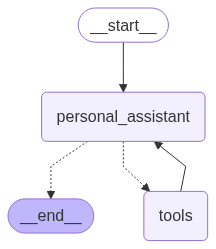

In [8]:

# Initialize memory checkpoint
checkpointer = InMemorySaver()
# memory = MemorySaver(State)
graph_builder = StateGraph(State)
graph_builder.add_node("personal_assistant", chatbot)
tools = ToolNode(tools)
graph_builder.add_node("tools", tools)
graph_builder.add_edge(START, "personal_assistant")
graph_builder.add_conditional_edges("personal_assistant", tools_condition)
graph_builder.add_edge("tools","personal_assistant")
graph = graph_builder.compile(checkpointer=checkpointer)
# graph = graph_builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass




In [10]:
config = {"configurable": {"thread_id": "1"}}
# graph.invoke({"messages":[{"role":'user',"content":"Hello! my name is amit I take lectures on BIA, also I like to Play Badminton"}]}, config)

In [10]:
graph.invoke({"messages":[{"role":"user","content": "I have many students who are quite bright theres names are Vijay, Pooja, Gautam, Omjee"}]}, config)

{'messages': [HumanMessage(content='I have many students who are quite bright theres names are Vijay, Pooja, Gautam, Omjee', additional_kwargs={}, response_metadata={}, id='70b8c76e-14ea-4c4c-aed7-26d90b6ba615'),
  AIMessage(content="It's great to hear that you have a group of bright students! If there's anything specific you'd like to know or discuss about them, feel free to let me know.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 111, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BuxW82YxUeVQeP4KvWPQFst5mqfes', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--efaf93df-d187-48c6-8e45-291c5bd4152c-0', usage_metadata={'input_token

In [11]:
graph.invoke({"messages":[{"role":"user","content": "do you remember my bright students?"}]}, config)

{'messages': [HumanMessage(content='do you remember my bright students?', additional_kwargs={}, response_metadata={}, id='aeebefea-2c0f-4f42-bc9b-68b65f5822f0'),
  AIMessage(content="I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. I am designed to respect user privacy and confidentiality. If you have any specific questions or need assistance, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 96, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BuxXECCNasP4KbtNaHOKuzdeXLIKf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--

In [12]:
graph.invoke({"messages":[{"role":"user","content": "whats the value of 3+4"}]}, config)

{'messages': [HumanMessage(content='Hello! my name is amit I take lectures on BIA, also I like to Play Badminton', additional_kwargs={}, response_metadata={}, id='1bc6008f-3d5b-43cc-9465-2dbad6325805'),
  AIMessage(content="Hello Amit! It's great to meet you. It sounds like you have a diverse set of interests, from teaching Business Intelligence and Analytics (BIA) to playing badminton. If there's anything specific you'd like to discuss or need help with, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 109, 'total_tokens': 164, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BuxQ5eHZPakA5j0Jh6LRcoLbElSXl', 'service_tier': 'default', 'finish_reason': 'stop', 'lo

###  Using a Redis Checkpointer (Persistent Memory with Redis)
For persistent, fast storage of conversation state across sessions, LangGraph provides a Redis-backed checkpointer. This requires a running Redis server and the langgraph-checkpoint-redis integration package
langchain-ai.github.io
. The state (conversation history) is saved in Redis so the agent can recall information even after the program restarts
redis.io


In [18]:
# docker run -d -p 6379:6379 --name redis-stack redis/redis-stack-server:latest
# from langgraph.checkpoint.redis import RedisSaver
# from langgraph.graph import StateGraph, MessagesState, START
# from langchain_openai import ChatOpenAI

# # Connect to Redis (adjust URL as needed; here we use default local Redis)
# DB_URI = "redis://localhost:6379"
# with RedisSaver.from_conn_string(DB_URI) as checkpointer:  # open Redis connection
#     checkpointer.setup()  # initialize Redis schema on first use (creates indexes):contentReference[oaicite:13]{index=13}
#     model = ChatOpenAI(temperature=0)
#     def call_model(state: MessagesState):
#         response = model(state["messages"])
#         return {"messages": response}

#     builder = StateGraph(MessagesState)
#     builder.add_node(call_model)
#     builder.add_edge(START, "call_model")
#     graph = builder.compile(checkpointer=checkpointer)
#     config = {"configurable": {"thread_id": "user123"}}

#     # **Session 1:** User introduces themselves (state will be saved to Redis)
#     graph.invoke(
#         {"messages": [{"role": "user", "content": "Hi, I'm Alice and I love chocolate."}]}, 
#         config
#     )
#     # The assistant's reply is now stored in Redis under thread "user123".

# # (At this point, the program could exit; the conversation state remains in Redis)

# # **Session 2:** Later on, we reconnect to Redis and resume the conversation
# with RedisSaver.from_conn_string(DB_URI) as checkpointer:  # re-open Redis connection
#     model = ChatOpenAI(temperature=0)
#     def call_model(state: MessagesState):
#         response = model(state["messages"])
#         return {"messages": response}

#     builder = StateGraph(MessagesState)
#     builder.add_node(call_model)
#     builder.add_edge(START, "call_model")
#     graph = builder.compile(checkpointer=checkpointer)
#     config = {"configurable": {"thread_id": "user123"}}

#     # User asks a question in a new session; the agent will load prior state from Redis
#     result = graph.invoke(
#         {"messages": [{"role": "user", "content": "Do you remember my name and what I like?"}]}, 
#         config
#     )
#     print(result["messages"][-1]["content"])
#     # Expected: "Yes, your name is Alice and you like chocolate."


### Using a SQLite Checkpointer (Persistent Local Memory)

In [12]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, MessagesState, START
from langchain_openai import ChatOpenAI

DB_PATH = "memory_store.db"  # SQLite database file for storing checkpoints

# **Session 1:** Create/open the SQLite DB and save the conversation state
with SqliteSaver.from_conn_string(DB_PATH) as checkpointer:  # opens connection to memory_store.db
    model = ChatOpenAI(temperature=0)
    def call_model(state: MessagesState):
        response = model(state["messages"])
        return {"messages": response}

    builder = StateGraph(MessagesState)
    builder.add_node(call_model)
    builder.add_edge(START, "call_model")
    graph = builder.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "user123"}}

    # User introduces themselves; state is saved to the SQLite file
    graph.invoke(
        {"messages":[{"role":'user',"content":"Hello! my name is amit I take lectures on BIA"}]}, 
        config
    )
    # After this call, the conversation (thread "user123") is stored in memory_store.db

# **Session 2:** Re-open the SQLite DB and resume the conversation
with SqliteSaver.from_conn_string(DB_PATH) as checkpointer:  # connect to the same DB file
    model = ChatOpenAI(temperature=0)
    def call_model(state: MessagesState):
        response = model(state["messages"])
        return {"messages": response}

    builder = StateGraph(MessagesState)
    builder.add_node(call_model)
    builder.add_edge(START, "call_model")
    graph = builder.compile(checkpointer=checkpointer)
    config = {"configurable": {"thread_id": "user123"}}

    # User asks a follow-up; the agent loads past state from the SQLite DB
    result = graph.invoke(
        {"messages": [{"role": "user", "content": "Do you remember my name and what I do?"}]}, 
        config
    )
    print(result["messages"][-1])
    # Expected agent output: "Your name is Alice and you like chocolate."


/var/folders/y3/l1qzr2852s51qbvnph6b1qf80000gp/T/ipykernel_3326/2227940345.py:11: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = model(state["messages"])


content='Yes, your name is Amit and you give lectures on Business Impact Analysis (BIA). How can I assist you today, Amit?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 80, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BuxdERrueUNJQjnErVWPYNnBfcVF3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--4469c7fc-dec5-4aac-857c-974d9b648fcd-0' usage_metadata={'input_tokens': 80, 'output_tokens': 27, 'total_tokens': 107, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


### Multi-Tool Research Assistant
    Task:
    Build a Research Assistant that can:
    Search the web for information [https://serpapi.com/]
    Summarize articles
    Save findings to a file
    Generate a final research report